In [1]:
import io
import itertools
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import pandas as pd
%matplotlib inline

### Meta Definition

In [2]:
mstr = """detector,sensor_id,location_name,location_abb,sensor_type
2144154,40262,Ecole Sainte-Trinité - capteur 1,EST-1,sds011
5107590,40260,Home Les Heures Douces - capteur 1,HHD-1,sds011
2144144,40258,Home Jean Van Aa - capteur 1,HVA-1,sds011
14544939,40096,Home Jean Van Aa - capteur 2,HVA-2,sds011
2129824,39672,Crèche Le Berceau - capteur 1,CLB-1,sds011
5110852,40092,Crèche Le Berceau - capteur 2,CLB-2,sds011
2129577,21944,Ecole européenne Bruxelles III - capteur 1,EEB3-1,dht22
2108900,21371,Ecole européenne Bruxelles III - capteur 2,EEB3-2,
5109108,21431,Ecole n°7 - capteur 1,E7-1,bme280
5110614,21432,Ecole n°7 - capteur 2,E7-2,
2129507,21429,Ecole n°8 - capteur 1,E8-1,dht22
5110442,21430,Ecole n°8 - capteur 2,E8-2,sds011"""

In [3]:
meta = pd.read_csv(io.StringIO(mstr))
meta

,detector,sensor_id,location_name,location_abb,sensor_type
0,2144154,40262,Ecole Sainte-Trinité - capteur 1,EST-1,sds011
1,5107590,40260,Home Les Heures Douces - capteur 1,HHD-1,sds011
2,2144144,40258,Home Jean Van Aa - capteur 1,HVA-1,sds011
3,14544939,40096,Home Jean Van Aa - capteur 2,HVA-2,sds011
4,2129824,39672,Crèche Le Berceau - capteur 1,CLB-1,sds011
5,5110852,40092,Crèche Le Berceau - capteur 2,CLB-2,sds011
6,2129577,21944,Ecole européenne Bruxelles III - capteur 1,EEB3-1,dht22
7,2108900,21371,Ecole européenne Bruxelles III - capteur 2,EEB3-2,NaN
8,5109108,21431,Ecole n°7 - capteur 1,E7-1,bme280
9,5110614,21432,Ecole n°7 - capteur 2,E7-2,NaN


## Session Handler

In [4]:
# Session Helper:
# https://stackoverflow.com/questions/23013220/max-retries-exceeded-with-url-in-requests
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

## Fetch Method

In [5]:
def fetch(meta, trange=None, show=False, meta_columns=['sensor_id', 'location_abb'], session=requests,
    url="https://archive.luftdaten.info/{date:%Y-%m-%d}/{date:%Y-%m-%d}_{sensor_type:}_sensor_{sensor_id:}.csv"):
    """
    Fetch Sensor Data from Luft Daten Project
    """
    # Default Time Range (last 7 days):
    if trange is None:
        trange = pd.date_range(end=pd.Timestamp.utcnow().floor('D'), freq='D', periods=7)
    # Data Processing:
    maj = []
    for m in meta.to_dict(orient='records'):
        dfs = []
        for t in trange:
            target = url.format(date=t, **m)
            rep = session.get(target, headers={'User-Agent': 'Mozilla/5.0'}, timeout=60)
            if show:
                print(rep, target)
            if (rep.status_code == 200) and (rep.headers['Content-Type'] == 'text/csv'):
                df = pd.read_csv(io.BytesIO(rep.content), sep=';', parse_dates=['timestamp'])
                dfs.append(df)
        if dfs:
            df = pd.concat(dfs, axis=0)
            maj.append(df)
    df = pd.concat(maj, axis=0, sort=False).dropna(how='all', axis=1)
    df = df.merge(meta.loc[:,meta_columns], on='sensor_id')
    return df

## Data

In [6]:
dt = pd.date_range('2020-02-10', '2020-03-10', freq='D')
df = fetch(meta, trange=dt, show=True)

<Response [200]> https://archive.luftdaten.info/2020-02-10/2020-02-10_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-11/2020-02-11_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-12/2020-02-12_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-13/2020-02-13_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-14/2020-02-14_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-15/2020-02-15_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-16/2020-02-16_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-17/2020-02-17_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-18/2020-02-18_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-19/2020-02-19_sds011_sensor_40262.csv
<Response [200]> https://archive.luftdaten.info/2020-02-20/2

<Response [200]> https://archive.luftdaten.info/2020-03-09/2020-03-09_sds011_sensor_40258.csv
<Response [404]> https://archive.luftdaten.info/2020-03-10/2020-03-10_sds011_sensor_40258.csv
<Response [404]> https://archive.luftdaten.info/2020-02-10/2020-02-10_sds011_sensor_40096.csv
<Response [404]> https://archive.luftdaten.info/2020-02-11/2020-02-11_sds011_sensor_40096.csv
<Response [404]> https://archive.luftdaten.info/2020-02-12/2020-02-12_sds011_sensor_40096.csv
<Response [200]> https://archive.luftdaten.info/2020-02-13/2020-02-13_sds011_sensor_40096.csv
<Response [200]> https://archive.luftdaten.info/2020-02-14/2020-02-14_sds011_sensor_40096.csv
<Response [200]> https://archive.luftdaten.info/2020-02-15/2020-02-15_sds011_sensor_40096.csv
<Response [200]> https://archive.luftdaten.info/2020-02-16/2020-02-16_sds011_sensor_40096.csv
<Response [200]> https://archive.luftdaten.info/2020-02-17/2020-02-17_sds011_sensor_40096.csv
<Response [404]> https://archive.luftdaten.info/2020-02-18/2

<Response [200]> https://archive.luftdaten.info/2020-03-07/2020-03-07_sds011_sensor_40092.csv
<Response [200]> https://archive.luftdaten.info/2020-03-08/2020-03-08_sds011_sensor_40092.csv
<Response [200]> https://archive.luftdaten.info/2020-03-09/2020-03-09_sds011_sensor_40092.csv
<Response [404]> https://archive.luftdaten.info/2020-03-10/2020-03-10_sds011_sensor_40092.csv
<Response [200]> https://archive.luftdaten.info/2020-02-10/2020-02-10_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-11/2020-02-11_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-12/2020-02-12_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-13/2020-02-13_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-14/2020-02-14_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-15/2020-02-15_dht22_sensor_21944.csv
<Response [200]> https://archive.luftdaten.info/2020-02-16/2020-02

<Response [200]> https://archive.luftdaten.info/2020-03-06/2020-03-06_bme280_sensor_21431.csv
<Response [200]> https://archive.luftdaten.info/2020-03-07/2020-03-07_bme280_sensor_21431.csv
<Response [200]> https://archive.luftdaten.info/2020-03-08/2020-03-08_bme280_sensor_21431.csv
<Response [200]> https://archive.luftdaten.info/2020-03-09/2020-03-09_bme280_sensor_21431.csv
<Response [404]> https://archive.luftdaten.info/2020-03-10/2020-03-10_bme280_sensor_21431.csv
<Response [404]> https://archive.luftdaten.info/2020-02-10/2020-02-10_nan_sensor_21432.csv
<Response [404]> https://archive.luftdaten.info/2020-02-11/2020-02-11_nan_sensor_21432.csv
<Response [404]> https://archive.luftdaten.info/2020-02-12/2020-02-12_nan_sensor_21432.csv
<Response [404]> https://archive.luftdaten.info/2020-02-13/2020-02-13_nan_sensor_21432.csv
<Response [404]> https://archive.luftdaten.info/2020-02-14/2020-02-14_nan_sensor_21432.csv
<Response [404]> https://archive.luftdaten.info/2020-02-15/2020-02-15_nan_s

<Response [200]> https://archive.luftdaten.info/2020-03-05/2020-03-05_sds011_sensor_21430.csv
<Response [200]> https://archive.luftdaten.info/2020-03-06/2020-03-06_sds011_sensor_21430.csv
<Response [200]> https://archive.luftdaten.info/2020-03-07/2020-03-07_sds011_sensor_21430.csv
<Response [200]> https://archive.luftdaten.info/2020-03-08/2020-03-08_sds011_sensor_21430.csv
<Response [200]> https://archive.luftdaten.info/2020-03-09/2020-03-09_sds011_sensor_21430.csv
<Response [404]> https://archive.luftdaten.info/2020-03-10/2020-03-10_sds011_sensor_21430.csv


In [7]:
df.sample(5)

,sensor_id,sensor_type,location,lat,lon,timestamp,P1,P2,temperature,humidity,pressure,location_abb
41707,40096,SDS011,26112,50.872,4.332,2020-02-16 15:03:13,3.97,1.92,NaN,NaN,NaN,HVA-2
15108,40262,SDS011,25980,50.826,4.376,2020-03-08 17:55:06,11.30,4.40,NaN,NaN,NaN,EST-1
99226,21429,DHT22,10875,50.444,30.540,2020-02-18 06:25:08,NaN,NaN,4.2,99.9,NaN,E8-1
35599,40258,SDS011,25978,50.824,4.378,2020-02-25 18:43:55,10.68,1.87,NaN,NaN,NaN,HVA-1
27676,40260,SDS011,25979,50.872,4.332,2020-03-02 18:39:46,8.82,4.50,NaN,NaN,NaN,HHD-1


## Post-processing

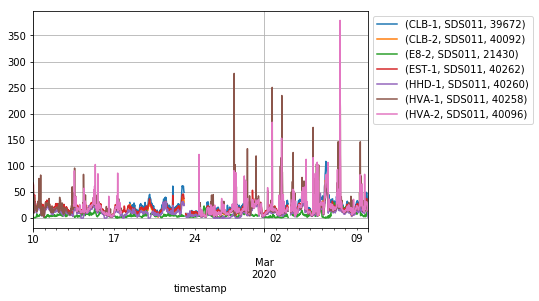

In [8]:
P1 = df.pivot_table(index='timestamp', columns=['location_abb', 'sensor_type', 'sensor_id'], values='P1')\
       .resample('30T').mean()
axe = P1.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

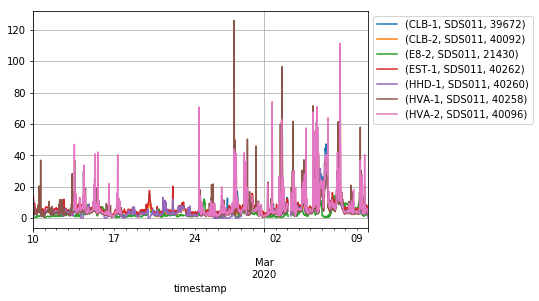

In [9]:
P2 = df.pivot_table(index='timestamp', columns=['location_abb', 'sensor_type', 'sensor_id'], values='P2')\
       .resample('30T').mean()
axe = P2.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

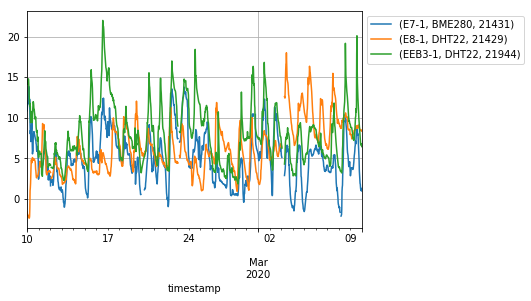

In [10]:
T = df.pivot_table(index='timestamp', columns=['location_abb', 'sensor_type', 'sensor_id'], values='temperature')\
       .resample('30T').mean()
axe = T.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

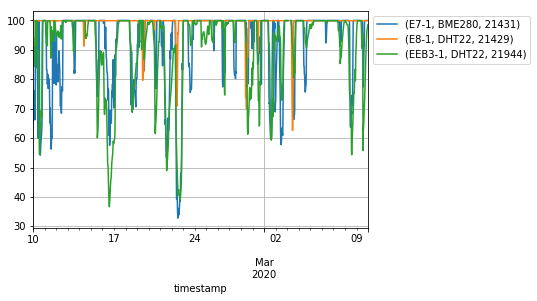

In [11]:
RH = df.pivot_table(index='timestamp', columns=['location_abb', 'sensor_type', 'sensor_id'], values='humidity')\
       .resample('30T').mean()
axe = RH.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

In [12]:
df.to_pickle("lca.pickle")